In [8]:
from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F
import math

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)), torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()
    W_xf, W_hf, b_f = three()
    W_xo, W_ho, b_o = three()
    W_xc, W_hc, b_c = three()
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [4]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), torch.zeros((batch_size, num_hiddens), device=device))

In [5]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

perplexity 1.1, 25970.7 tokens/sec on cuda:0
time traveller  it s against reason said filby  what reason said
traveller thitherine the merical in a dichtrland thin that 


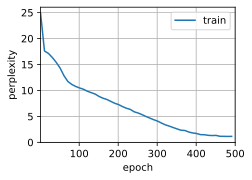

In [6]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params, init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [9]:
class RNNModel(nn.Module):  #@save
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        
        if not self.rnn.bidirectional:
            self.num_directions=1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
        
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device)
    
        else:
            return (torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device), 
                    torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device))

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter): #@save
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            d2l.grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            d2l.grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False): #@save
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.1, 298662.2 tokens/sec on cuda:0
time traveller  it s against reason said filby  what reason said
traveller  it s against reason said filby  what reason said


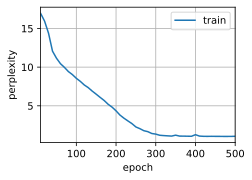

In [10]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)